## Assignment 1
### Author:
Preeti Gupta

*Misc Items to include*
1. Which forum you chose (provide URL) 
2. Which 10 brands you chose – provide the frequency table
3. Show all lift calculations in a table. 
4. MDS map 
5. State the 5 attributes you chose (again, a table is good here). 
6. For task E, provide all details of your analysis – e.g., how you measured “aspirational” and how you found the most aspirational brand.  
7. Advice/insights based on your analysis for your client. 

In [4]:
## Imports
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from statistics import mean
from sklearn.manifold import MDS
import sklearn.datasets as dt
import seaborn as sns
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import os
import re
import nltk
import requests
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jloes\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
import os, ssl
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and
getattr(ssl, '_create_unverified_context', None)):
    ssl._create_default_https_context = ssl._create_unverified_context

### Task 0
Write a scaper

In [54]:
cwd = os.getcwd()

if not os.path.isfile(cwd + '/results.csv'):
    df = pd.DataFrame(columns=['Date', 'message'])
    URL = "https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans"
    page = requests.get(URL)

    x = 0
    
    '''TQDM :
    tqdm is a library in Python which is used for creating Progress Meters or Progress Bars. 
    tqdm got its name from the Arabic name taqaddum which means ‘progress’.'''
    for i in tqdm(range(1,250)):

        if i == 1:
            URL = "https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans"
        else:
            URL = "https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p%i" %i
        page = requests.get(URL)

        soup = BeautifulSoup(page.content, "html.parser")
        
        '''Beautiful Soup is a Python library that is used for web scraping purposes to pull the data out of HTML and XML files. 
        It creates a parse tree from page source code that can be used to extract data in a hierarchical and more readable manner.'''
        comments = soup.find_all("div", class_="Comment")
        for comment in comments:
            time = comment.find("time")
            message = comment.find("div", class_="Message userContent")
            time = time.text
            message = message.text
            df.loc[x, 'Date'] = time
            df.loc[x, 'message'] = message
            x += 1
    
    #sending results to csv      
    df.to_csv("results.csv", sep="\t")
    
else:
    print('Results file already exists in cwd, loading results.csv into df now...')
    df = pd.read_csv('results.csv', sep='\t').drop(['Unnamed: 0'], axis=1)

Results file already exists in cwd, loading results.csv into df now...


In [55]:
#selecting message only and creating new df

s_sentence_withstopwords = df['message'].apply(lambda x : x.strip('\n'))
s_sentence_withstopwords.head(2)

0    I personally think that with a few tweaks the ...
1    I am debating a new purchase and these two are...
Name: message, dtype: object

In [56]:
#sepearating by word and removing stop words
from IPython.core.debugger import set_trace

if not os.path.isfile(cwd + '/words_stop.csv') or not os.path.isfile(cwd + '/words_no_stop.csv'):
    with_stop_words = []
    for idx, sentence in tqdm(s_sentence_withstopwords.items()): ## items() to get the key value pairs index and sentences
        for word in list(set(sentence.split())):  ## set to get one word only once from a single comment
            word = re.sub(r'\W+', '', word) # removes all special characters
            with_stop_words.append(word.strip().lower()) # lower # strip removes any leading or trailing space character by default
           
    no_stop_words = []
    for word in tqdm(with_stop_words):
        if word.lower() not in stopwords.words('english'):
            no_stop_words.append(word.lower()) 
            
    s_words_withoutstopwords = pd.Series(no_stop_words)
    s_words_withstopwords = pd.Series(with_stop_words)
    
    s_words_tok = []
    for word in tqdm(s_words_withoutstopwords):
      tokenizer = nltk.RegexpTokenizer(r"\w+")
      try:
        new_word = tokenizer.tokenize(word)
        s_words_tok.append(new_word[0])
      except IndexError:
        pass
    
    s_words_withoutstopwords = pd.Series(s_words_tok)
    s_words_withstopwords.to_csv('words_stop.csv', index=False)
    s_words_withoutstopwords.to_csv('words_no_stop.csv', index=False)
else:
    print('Words have already been processed, loading now...')
    s_words_withstopwords = pd.read_csv('words_stop.csv')['0']
    s_words_withoutstopwords = pd.read_csv('words_no_stop.csv')['0']

Words have already been processed, loading now...


In [57]:
s_words_withstopwords.value_counts()

the              14200
a                 9675
and               9516
to                8724
is                8639
                 ...  
umpteenth            1
movesinterior        1
linkregarding        1
unaffordably         1
aug02                1
Name: 0, Length: 49103, dtype: int64

In [58]:
s_words_withoutstopwords.value_counts()

car                5854
cars               3492
like               3252
bmw                3210
one                3083
                   ... 
dale                  1
lineis                1
assumptionsfrom       1
listour               1
2005325i              1
Name: 0, Length: 48964, dtype: int64

In [59]:
top_word = s_words_withoutstopwords.value_counts().index.to_list()[0]
top_frequency = s_words_withoutstopwords.value_counts().iloc[0]
print('The word with the highest frequency is "%s": %d'%(top_word, top_frequency))

The word with the highest frequency is "car": 5854


### Task A
Once you fetch the data, test if the data support Zipf’s law. Plot the most common 100 words in the data against the theoretical prediction of the law. For this question, do not remove stopwords. Also do not perform stemming or lemmatization. 

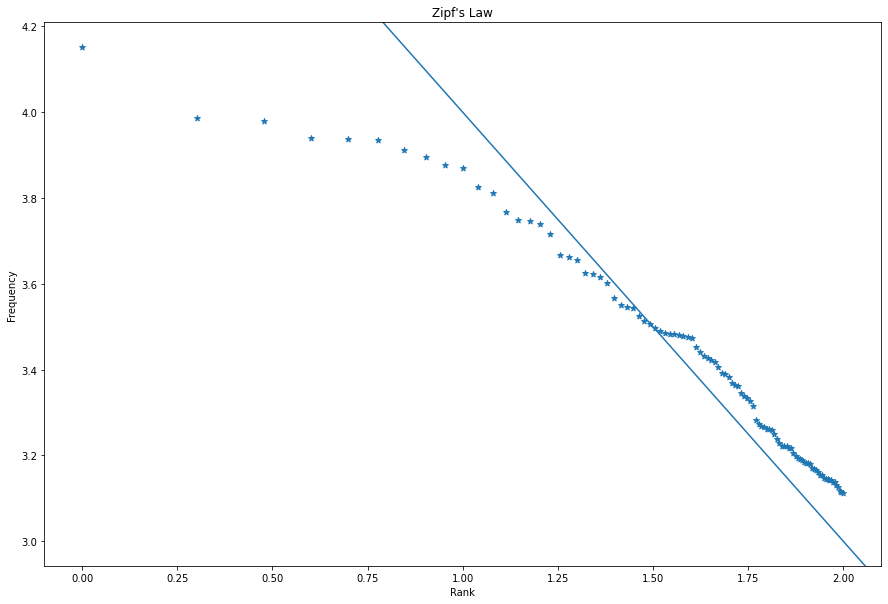

In [60]:
#Zipf's law with plotted line on df with stop words
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

words = list(s_words_withstopwords.value_counts().index)
counts = s_words_withstopwords.value_counts().to_list()

idxs = [i for i in range(1, s_words_withstopwords.value_counts().count() + 1)]
df_words_withstopwords = pd.DataFrame(data={'word': words, 'count': counts}, index=idxs)

first_100x = np.log10(df_words_withstopwords.index[:100]).tolist()
first_100y = np.log10(df_words_withstopwords["count"].loc[:100]).tolist()

f, ax = plt.subplots(figsize = (15,10))
ax.scatter(first_100x, first_100y, marker='*')
plt.title("Zipf's Law")
plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.axline(xy1= (2,3), slope=-1)

In [61]:
#Proving Zipf's law 
#lnr = theta * ln(xr/n*xn)
#theta = ln(xr/n*xn)/lnr

#divide by two because there are two column in the df
n = int(df_words_withstopwords.size/2)
xn = counts[-1]

#test if theta = -1
theta_list = []
#np.log()
for xr in df_words_withstopwords.index-1: 
    #print(xr)
    r = df_words_withstopwords.iloc[xr]['count']
    if r != 1:
        theta_list.append(np.log(xr/n*xn)/np.log(r))
    
#avg_theta = sum(theta_list)/len(theta_list)

#the first thetas in the list shows that theta is indeed ~-1
print(theta_list[1:10])

<ipython-input-61-0f426eede60b>:16: RuntimeWarning: divide by zero encountered in log
  theta_list.append(np.log(xr/n*xn)/np.log(r))


[-1.1769992047930127, -1.1034631926748892, -1.0693455551687605, -1.038761838460247, -1.014428663631466, -1.0002421774988666, -0.9873852737780359, -0.9768536530840695, -0.965541370632425]


In [62]:
mean_theta = np.array(theta_list[1:]).mean()
theta_list
mean_theta


-1.2438221841250439

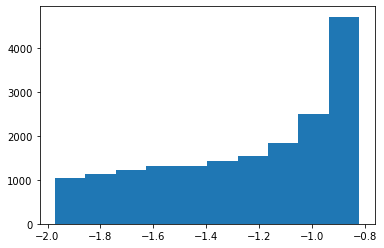

In [63]:
import matplotlib.pyplot as plt
plt.hist(np.array(theta_list[1:]))
plt.show()

In [64]:
theta_std = np.array(theta_list[1:]).std()
theta_std
up_range = mean_theta + theta_std
low_range = mean_theta - theta_std

In [65]:
within_one_std = np.where(theta_list[1:]<= up_range) or np.where(theta_list[1:]>= low_range)

In [66]:
percentage_within_one_std = (within_one_std[0].shape[0]/ (len(theta_list)-1))*100
percentage_within_one_std

79.2988868582821

### Task B
Find the top 10 brands from frequency counts. You will need to write a script to count the frequencies of words (stopwords should NOT be counted). Replace frequently occurring car models with brands so that from now on you have to deal with only brands and not models. You will need another script for this job. A list of model and brand names (not exhaustive) are provided in a separate file. 

In [67]:
car_models = pd.read_csv('car models brands.csv')
model_list = car_models['Model'].to_list()

#check if word is in card_model array and changes it the brand
def brand_changer(words):
    newlist = []
    for word in words:
        if word in model_list:
          #if word in model array change it to the corresponding brand
            newlist.append(car_models[car_models['Model']==word]['Brand'].values[0])
        else:
            newlist.append(word)
            
    return newlist

#make brand into dictionary with initial value as 0
brands = list(car_models['Brand'].unique())

#counts frequency of each brand, returns array of tupples with top 10 brands: [(brand, frequency),(brand,frequncy),...etc]
def brand_freq(words):
    brand_count = dict.fromkeys(brands, 0)
    
    for word in words:
        if word in list(brand_count.keys()):
            brand_count[word] +=1
    
    return sorted(brand_count.items(),  key=lambda x: x[1], reverse=True)[:11]

words_brand_filtered = pd.Series(brand_changer(s_words_withoutstopwords.to_list()))
sorted_brand_freq = pd.Series(brand_freq(words_brand_filtered.to_list()))

In [68]:
# top 10 sorted brands
sorted_brand_freq

0           (bmw, 5579)
1          (audi, 1991)
2         (acura, 1928)
3         (honda, 1367)
4      (infiniti, 1264)
5         (nissan, 787)
6         (toyota, 730)
7          (volvo, 594)
8     (volkswagen, 581)
9         (subaru, 434)
10          (ford, 425)
dtype: object

### Task C
Calculate lift ratios for associations between the top-10 brands identified in Task A. You will have to write a script to do this task). For lift calculations, be sure not to count a mention more than once per post, even if it is mentioned multiple times in the post.

In [69]:
#takes out top 10 brands from tuple in sorted brand freq
brands = [ item[0] for item in sorted_brand_freq]

In [70]:
 #finds lift between two entities
def lift(A, B, messages):
    A=A.lower()
    B=B.lower()
    A_count = 0
    B_count = 0
    AB_count = 0
    n=len(messages)
    for message in messages:
      message=message.lower()
      if A in message:
        A_count+=1
      if B in message:
        B_count+=1
      if A in message and B in message:
        AB_count+=1
    lift_val= (n*AB_count)/(A_count*B_count)
    if A == B:
      return ""
    else:
      return round(lift_val,4)

#utilizes lift function above and runs agaainst all the brands in the brand list. Returns dataframe of lift values with useless values removed
def lift_everything(brands,messages):
  results=[]
  counter=0
  for b in brands:
    results.append([])
    for f in brands:
      k=lift(b,f,messages)
      results[counter].append(k)
    counter+=1
  import numpy as np
  triangle = np.triu (results)
  import pandas as pd
  return pd.DataFrame(triangle, columns=[brands], index=[brands])

In [71]:
#made array with all the messsages with brand 
messages_with_brands = []
for message in tqdm(s_sentence_withstopwords):
  tokenizer = nltk.RegexpTokenizer(r"\w+")
  message_tok = tokenizer.tokenize(message)
  words = " ".join(message_tok).lower().split()
  messages_with_brands.append(" ".join(brand_changer(words)))

100%|███████████████████████████████████████████████████████████████████████| 12450/12450 [00:07<00:00, 1755.10it/s]


In [72]:
lifted = lift_everything(brands,messages_with_brands)
lifted

,bmw,audi,acura,honda,infiniti,nissan,toyota,volvo,volkswagen,subaru,ford
bmw,,1.6587,1.3729,1.2342,1.7251,1.0943,1.4456,1.4506,1.4424,1.2159,1.5295
audi,,,2.2333,1.5763,2.3254,1.2029,1.4986,3.4809,3.9705,1.8712,1.7408
acura,,,,2.9586,3.0253,2.1542,1.601,2.6126,2.0086,1.7841,1.466
honda,,,,,1.6737,3.335,3.4832,2.2141,2.8064,1.7592,2.2164
infiniti,,,,,,3.0718,1.7305,2.2559,1.9849,1.6271,1.4347
nissan,,,,,,,4.0075,2.2213,2.5129,2.0734,2.1976
toyota,,,,,,,,2.1951,2.1205,1.5967,2.5065
volvo,,,,,,,,,3.0539,3.9582,3.3879
volkswagen,,,,,,,,,,3.2478,2.2539
subaru,,,,,,,,,,,2.1911


### Task D
Show the brands on a multi-dimensional scaling (MDS) map (use a Python script for MDS, there are multiple scripts available on GitHub). 

In [73]:
def lift_dissim(A, B, messages):
    A=A.lower()
    B=B.lower()
    A_count = 0
    B_count = 0
    AB_count = 0
    n=len(messages)
    for message in messages:
      message=message.lower()
      if A in message:
        A_count+=1
      if B in message:
        B_count+=1
      if A in message and B in message:
        AB_count+=1
    lift_val= (n*AB_count)/(A_count*B_count)
    return round(lift_val,4)
def lift_everything_dissimilarities(brands,messages):
  results=[]
  counter=0
  for b in brands:
    results.append([])
    for f in brands:
      k=lift_dissim(b,f,messages)
      results[counter].append(1/k)
    counter+=1
  return pd.DataFrame(results, columns=[brands], index=[brands])

In [74]:
lifted_dissim = lift_everything_dissimilarities(brands,messages_with_brands)
lifted_dissim

,bmw,audi,acura,honda,infiniti,nissan,toyota,volvo,volkswagen,subaru,ford
bmw,0.312373,0.602882,0.728385,0.810241,0.579677,0.913826,0.691754,0.689370,0.693289,0.822436,0.653808
audi,0.602882,0.117349,0.447768,0.634397,0.430034,0.831324,0.667289,0.287282,0.251857,0.534416,0.574449
acura,0.728385,0.447768,0.124740,0.337998,0.330546,0.464209,0.624610,0.382760,0.497859,0.560507,0.682128
honda,0.810241,0.634397,0.337998,0.087711,0.597479,0.299850,0.287092,0.451651,0.356328,0.568440,0.451182
infiniti,0.579677,0.430034,0.330546,0.597479,0.093012,0.325542,0.577868,0.443282,0.503804,0.614590,0.697010
nissan,0.913826,0.831324,0.464209,0.299850,0.325542,0.047229,0.249532,0.450187,0.397947,0.482300,0.455042
toyota,0.691754,0.667289,0.624610,0.287092,0.577868,0.249532,0.053896,0.455560,0.471587,0.626292,0.398963
volvo,0.689370,0.287282,0.382760,0.451651,0.443282,0.450187,0.455560,0.035984,0.327450,0.252640,0.295168
volkswagen,0.693289,0.251857,0.497859,0.356328,0.503804,0.397947,0.471587,0.327450,0.036546,0.307901,0.443675
subaru,0.822436,0.534416,0.560507,0.568440,0.614590,0.482300,0.626292,0.252640,0.307901,0.027068,0.456392


In [75]:
mds = MDS(random_state=0)
X_transform = mds.fit_transform(lifted_dissim)

print(X_transform)

[[ 0.48757066 -0.90618798]
 [-0.30887914 -0.5839893 ]
 [ 0.16345472 -0.22227198]
 [ 0.16961807  0.39283443]
 [ 0.41482825 -0.26162459]
 [ 0.5116087   0.42372899]
 [ 0.24487476  0.59271128]
 [-0.42450621 -0.10671976]
 [-0.31877369  0.08325317]
 [-0.63380096  0.07541225]
 [-0.30599515  0.51285351]]


C:\Users\jloes\anaconda3\lib\site-packages\sklearn\manifold\_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


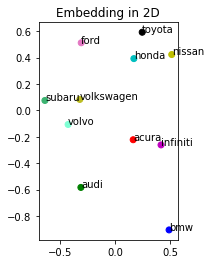

In [76]:
fig = plt.figure()

ax = fig.add_subplot(122)
plt.scatter(X_transform[:,0], X_transform[:,1], c=['b','g','r','c','m','y','k','aquamarine','tab:olive','mediumseagreen','tab:pink'])
for i, txt in enumerate(brands):
    ax.annotate(txt, (X_transform[:,0][i], X_transform[:,1][i]))
plt.title('Embedding in 2D')
fig.subplots_adjust(wspace=.4, hspace=0.5)
plt.show()

### Task E
What insights can you offer to your client from your analyses in Tasks C and D 

The highest association between car brands is in between Nissan and Toyota suggesting that these two brands are viewed similarly and as close competitors to one another. While neither of these brands is necessarily a luxury brand, the association between them should still be noted as they have the highest amount of co-occurrences. In terms of luxury brands (BMW, Audi, Acura, and Infiniti) Acura and Infiniti are discussed the most in conjunction. From Acura’s perspective perhaps focusing on gaining some market share from Infiniti would be more useful and effective than attempting to compete against more expensive luxury cars such as BMW. BMW and Acura have the lowest lift value among the luxury brands suggesting these brands may have stronger followings and are not often compared/contrasted together. This reiterates the point that Acura should focus on competing with brands more similar to itself, that way its marketing dollars can be spent more efficiently.  Another data point to consider is the association between Audi and Volkswagen. Volkswagen is the parent company of Audi so it makes sense why they are mentioned frequently together; however Acura and Honda (Honda is the parent company of Acura) are not mentioned as frequently. It may be worth performing further sentiment analysis in order to discern if the reputation of the parent company may affect the perception of its luxury brands.

Looking at the MDS graph, it echoes several of the points above, while allowing us to visualize the similarities of the brands. There is a cluster of Toyota, Nissan and Honda, which reflects their high lift values. As aforementioned, Acura and Infiniti are close together, with BMW far removed from their cluster. This MDS graph can be a very useful tool in identifying a brand’s closest group of competitors. This information coupled with the lift values can help marketing departments target specific customers and identify which customers may have a slower switching cost than others (i.e. it's easier to get an Infiniti customer to switch to an Acura than a BMW customer). These insights can ensure that marketing campaigns are more targeted and efficient. 


### Part F
What are 5 most frequently mentioned attributes or features of cars in the discussions? Which attributes are most strongly associated with which of these 5 brands? You DON’T have to do a sentiment analysis for this assignment.

In [77]:
attributes = ['new', 'performance','interior', 'manual', 'handling']
brands = ['bmw', 'honda', 'toyota', 'acura', 'audi']

brand_attribute_lift = pd.DataFrame(index = brands, columns = attributes)

for brand, attributes in list(brand_attribute_lift.iterrows()):
    for attribute in attributes.index: 
        brand_attribute_lift.loc[brand][attribute] = lift(brand, attribute, s_sentence_withstopwords.to_list())
print(brand_attribute_lift)

           new performance interior  manual handling
bmw     1.5537       1.549   1.4758  1.3958   1.7334
honda   1.8341      1.4509   1.2926  1.3852   1.6567
toyota  1.4631      1.0271   1.0944  1.3446   1.0232
acura   1.6208      1.7065   1.6851  1.2618   1.6633
audi    1.7883      1.5733   2.6792  1.6126   1.8259


In [78]:
"""
New: Honda
Performance: Acura
Interior: Audi
Manual: Audi
Handling: Audi
"""

'\nNew: Honda\nPerformance: Acura\nInterior: Audi\nManual: Audi\nHandling: Audi\n'

### Task G
What advice will you give to your client from Task F? For this assignment, you can assume that all sentiments are positive. 

Based off of the insights gained from Task F we can make several specific recommendations to our clients based upon the association of top features to brands. 

BMW: BMW appears to be competing with Acura and Audi when it comes to performance, with Acura being the clear performance leader and Audi/BMW being closely associated when its comes to their brand's relationship to performance. We recommend that BMW pushes their marketing to be more heavily focused on emphasizing performance while distancing themselves from Acura by comparing the two car's handling, in which it appears that BMW marginally has a better association to handling than Acura. 
Honda: It appears that people prefer new Honda's more than any new car from the other top brands we compared it against. Honda was not very competitive compared to the other brands associations with key attributes, because of this we think their best strategy would be to continue to distance themselves from other brands by focusing on promoting the purchase of new Hondas.
Toyota: Toyota performed the worst of all the brands we analyzed when it came to association to key attributes. With low performance in relationship to being a new car, performance, interior, manual, and handling it is clear that while Toyota is a top selling brand, it is not a luxury brand. Because of this, we recommend that Toyota focus on making itself the #1 luxury car alternative. This can be done by focusing on attributes that do not have high association to luxury brands and continueing to promote their existing brand attributes.  
Acura: Acura saw the highest association to performance of all brands analyzed. While they effectively competed with other brands when it comes to handling, they significally lagged behind Audi when it came to interior. We recommend that Acura leans into their performance lead in order to continue to differentiate themselves form Audi as a luxury perforamnce brand. 
Audi: Audi is the leading brand when it comes to association to interior, manual, and handling. With this, Audi is the clear luxury brand leader of the brands we analyzed. We recommend that Audi continue to lean into these leads, specifically when it comes to their interior where is has a lift value of 2.68 compared to the next brand being Acura with an association of 1.69. By emphasizing these attributes Audi can maintain and expand their lead on other luxury brands.  

### Task H
Which is the most aspirational brand in your data in terms of people actually wanting to buy or own? Describe your analysis. What are the business implications for this brand?

In [79]:
'''given a post find the number of times a brand is positively associated with the words in aspiration_dict and accordingly
increase their aspirational rank.'''

df = pd.read_csv("results.csv", sep="\t")
aspiration_dict = ["love to", "want to own", "want to buy", "suggest", "impressed with", "dream of", "wish to", "wish of", "dream to", "dream of", "best", "favourite", "to own", "to buy", "imagine of"]
negate_dict = ["not", "never", "will not", "won't", "shall not", "shouldn't"]

In [80]:
brands = pd.read_csv("car models brands.csv", sep="\t")
brand =[]
model = []
for i in range(0, len(brands['Brand,Model'])): 
    brand.append(brands['Brand,Model'][i].split(',')[0])
    model.append(brands['Brand,Model'][i].split(',')[1])
unique_brand = np.unique(brand)
unique_brand

array(['acura', 'audi', 'bmw', 'buick', 'cadillac', 'chevrolet',
       'chrysler', 'dodge', 'ford', 'honda', 'hyndai kia', 'hyundai',
       'hyundai.', 'infiniti', 'kia', 'kia.', 'lincoln', 'mazda',
       'mercedes', 'mercedes benz', 'mercedes-benz', 'mercury',
       'mitsubishi', 'nissan', 'nissan.', 'pontiac', 'saturn', 'subaru',
       'suzuki', 'toyata', 'toyota', 'volkswagen', 'volkwagen', 'volvo'],
      dtype='<U13')

In [81]:
row_id = 0
car_models = pd.read_csv('car models brands.csv')
model_list = car_models['Model'].to_list()

def brand_changer(words):
    newlist = []
    for word in words:
        if word in model_list:
            print(word)
          #if word in model array change it to the corresponding brand
            #print(car_models[car_models['Model']==word]['Brand'])
            #newlist.append(car_models[car_models['Model']==word]['Brand'].values[0])
            words.replace(word, car_models[car_models['Model']==word]['Brand'].values[0])
  

            #print(newlist)
        else:
            continue
            #newlist.append(word)
    print(newlist)        
    return newlist

def get_brand_name_in_sentence(sentence):
    brands_in = []
    for brand_name in unique_brand:
        if brand_name in sentence:
            brands_in.append(brand_name)
    return brands_in   
  
def get_negate(sentence):
    for negation in negate_dict:
        if negation in sentence:
            # negative sentiment
            return 1
    return 0

aspiration_rank = []
for brand_name in unique_brand:
    
    #aspiration_rank.append(brand_name : 0)
    aspiration_rank.append([brand_name, 0])
    #aspiration_rank = np.zeroes(len(unique_brand))
aspiration_rank    
    
def update_aspirational_rank(aspiration_rank, brands_in):
    
    for i in range(0,len(aspiration_rank)):
        if aspiration_rank[i][0] in brands_in:
            aspiration_rank[i][1] = aspiration_rank[i][1] +1
        #print(aspiration_rank)
    return aspiration_rank

model_list = car_models['Model'].to_list()

#check if word is in card_model array and changes it the brand


def brand_changer(words):
    newlist = " "
    for word in words:
        if word in model_list:
            print(word)
            print(newlist)
            newlist = newlist.join(car_models[car_models['Model']==word]['Brand'].values[0] + " ")
            #if word in model array change it to the corresponding brand
            #newlist.append(car_models[car_models['Model']==word]['Brand'].values[0])
        else:
            newlist = newlist.join(word + " ")
            
    return newlist
        
for post_len in range(0, len(df["message"])): 
    post = df["message"][post_len]
    #post = brand_changer(post_original.split(" "))
    #post = brand_changer(post_original)

    #print(post)
        
    for brand_name in unique_brand:
        if brand_name in post:
            # remove the model names with brand names 
            for word in model_list:
                if word in post:
                    #print(word)
                    post.replace(word, car_models[car_models['Model']==word]['Brand'].values[0])
                    #print(car_models[car_models['Model']==word]['Brand'].values[0])
            #print(row_id)
            #string.find("substring")
            for aspiration_phrase in aspiration_dict:                   
                if post.find(str(aspiration_phrase)) !=-1:
                    brands_in = get_brand_name_in_sentence(post)                   
                    ## positive sentiment
                    if not get_negate(post):
                        aspiration_rank = update_aspirational_rank(aspiration_rank, brands_in)
                    break;
            break;
                        ## 
                #a.loc[row_id] = [row_id, post_len , post[sentence_len]]                
print("aspiration vector created")
aspiration_rank_sorted = sorted(aspiration_rank, key= lambda x :-x[1] )
#aspiration_rank_sorted

aspiration vector created


In [82]:
# most_aspired_brand (ignoring first one as it is word car)

most_aspired_brand = aspiration_rank_sorted[0][0]
print(most_aspired_brand)

ford


From our analysis we see that Ford turns out to be the most aspirational brand. It is the brand which is associated with phrases such as “want to buy”, “want to own”, “would love to have” etc. 
Ford can use this information in it’s branding as a key point that they are the most aspirational brand. Ford could also use this information to realise that since it is already the most aspired brand, it does not need to spend a lot on it’s branding and hence can utilise part of that money in some other sector. 

Other brands can learn from Ford’s branding and marketing strategy as reference when creating their own in order to create a similar branding and fan-following.
Since Ford has a very high reputation in the customer’s eyes, it might be very difficult  for other brands to compete with it. Rather they can take customers from other brands such as infiniti or Acura since they may have lower switching costs than the brand loyalty Ford  has.
